In [1]:
import torch
import matplotlib
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

import utils.model as model
import utils.dataset as dataset
import utils.skel as skel

from utils.dataset import SIGNUMDataset
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader
from IPython.display import clear_output

In [2]:
test_dataset = SIGNUMDataset('/scratch/datasets/SIGNUM', use_pose=True, subsample=10)
test_dataloader = DataLoader(test_dataset, batch_size=3, shuffle=False, num_workers=0, collate_fn=test_dataset.collate)

In [3]:
language_encoder = model.language_encoder()
pose_encoder = model.Encoder()
pose_decoder = model.Decoder(hidden_size=768, pose_size=57*2, trajectory_size=0,
               use_h=False, start_zero=False, use_tp=False,
               use_lang=False, use_attn=False)

/scratch/abi/venv/ms/lib/python3.6/site-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [4]:
num_joints = 57
joint_dim = 2
num_epochs = 50

loss_fn = torch.nn.MSELoss()
optimizerDecoder = torch.optim.SGD(pose_decoder.parameters(), lr=0.1)

In [5]:
for epoch in range(num_epochs):
    for i, data in enumerate(test_dataloader):
        if i == 1:
            break
        optimizerDecoder.zero_grad()
        
        img_seq = torch.FloatTensor(data['img_seq'])
        pose_seq = data['pose_seq']
        label_seq = data['label_seq']
        transl_eng = data['transl_eng']
        transl_deu = data['transl_deu']
        img_seq_len = data['seq_len']
        
        total_sequence = sum(np.array(img_seq_len))
        
        lang_embed = torch.FloatTensor(language_encoder(transl_eng))
#         print(img_seq_len)
#         print(pose_seq.shape)
#         print(label_seq.shape)

        output = pose_decoder(lang_embed, max(img_seq_len), pose_seq.view(pose_seq.shape[0], pose_seq.shape[1], -1),\
                              epoch=epoch)
#         print(output.shape)
#         print(np.array(img_seq_len)-1)
        pred_pose = dataset.unpad_sequence(output, img_seq_len).data
#         print(pred_pose.shape)

        gt_label = dataset.unpad_sequence(label_seq, np.array(img_seq_len)).data.view(-1, num_joints*joint_dim)
#         print(gt_label.shape)
#         print(gt_label[0])

#         mean = test_dataset.mean.unsqueeze(0).repeat(total_sequence, 1, 1)
#         std = test_dataset.std.unsqueeze(0).repeat(total_sequence, 1, 1)
#         denorm_output = skel.denormalize_pose(pred_pose.view(-1, 57, 2), mean, std)
#         denorm_label = skel.denormalize_pose(gt_label.view(-1, 57, 2), mean, std)

        loss = loss_fn(pred_pose, gt_label)
#         loss = loss_fn(denorm_output, denorm_label)
        loss.backward()
        optimizerDecoder.step()
        print(loss)

tensor(2.3609, grad_fn=<MseLossBackward>)
tensor(2.0674, grad_fn=<MseLossBackward>)
tensor(2.1733, grad_fn=<MseLossBackward>)
tensor(1.5859, grad_fn=<MseLossBackward>)
tensor(1.2662, grad_fn=<MseLossBackward>)
tensor(1.1167, grad_fn=<MseLossBackward>)
tensor(1.0036, grad_fn=<MseLossBackward>)
tensor(0.9629, grad_fn=<MseLossBackward>)
tensor(0.9279, grad_fn=<MseLossBackward>)
tensor(0.9120, grad_fn=<MseLossBackward>)
tensor(0.9022, grad_fn=<MseLossBackward>)
tensor(0.8869, grad_fn=<MseLossBackward>)
tensor(0.8797, grad_fn=<MseLossBackward>)
tensor(0.8744, grad_fn=<MseLossBackward>)
tensor(0.8690, grad_fn=<MseLossBackward>)
tensor(0.8613, grad_fn=<MseLossBackward>)
tensor(0.8547, grad_fn=<MseLossBackward>)
tensor(0.8494, grad_fn=<MseLossBackward>)
tensor(0.8453, grad_fn=<MseLossBackward>)
tensor(0.8416, grad_fn=<MseLossBackward>)
tensor(0.8382, grad_fn=<MseLossBackward>)
tensor(0.8350, grad_fn=<MseLossBackward>)
tensor(0.8319, grad_fn=<MseLossBackward>)
tensor(0.8289, grad_fn=<MseLossBac

In [6]:
vis_pose = pred_pose.view(pred_pose.shape[0], -1 , 2).detach()
print(vis_pose.shape)

torch.Size([39, 57, 2])


In [7]:
vis_gt = gt_label.view(pred_pose.shape[0], -1 , 2).detach()
print(vis_gt.shape)

torch.Size([39, 57, 2])


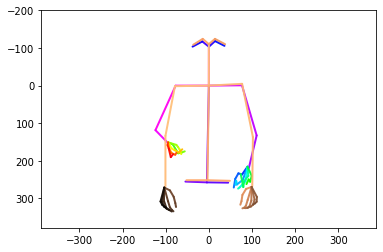

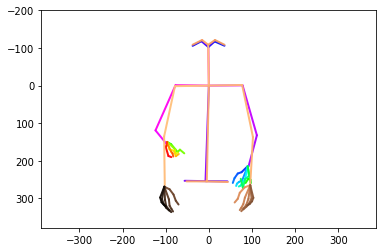

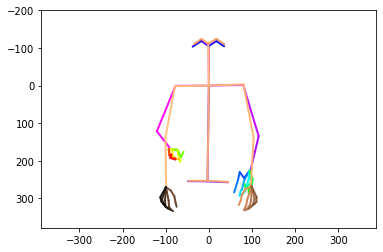

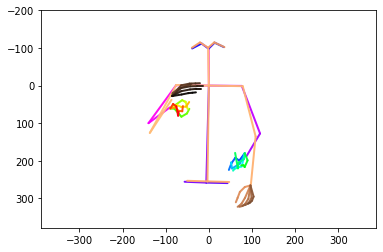

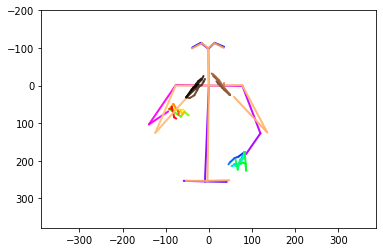

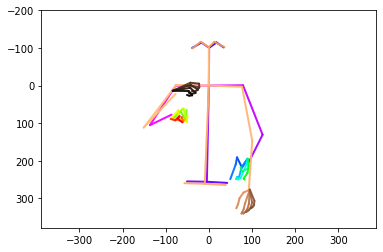

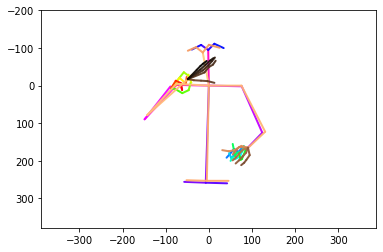

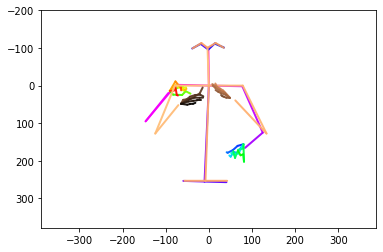

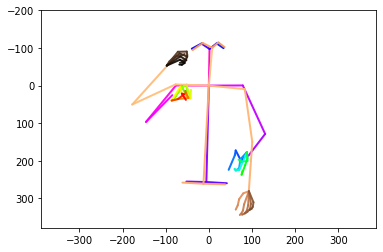

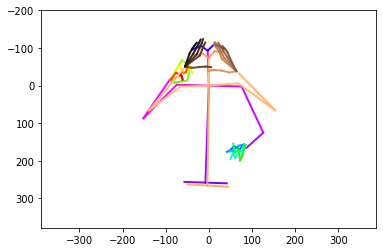

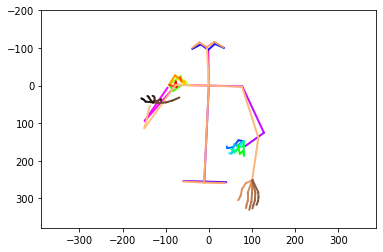

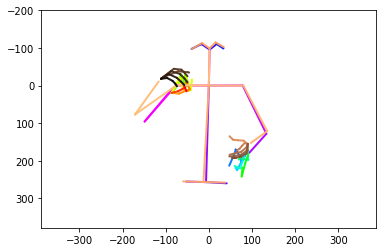

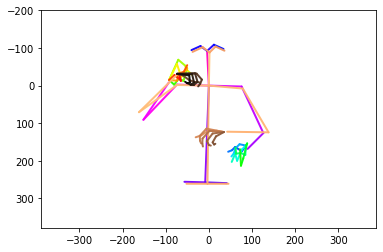

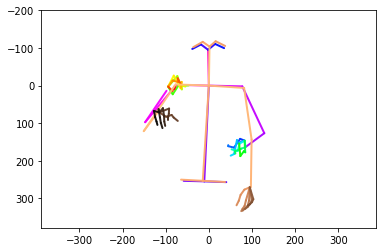

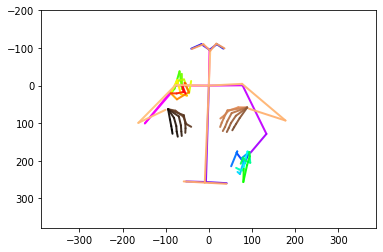

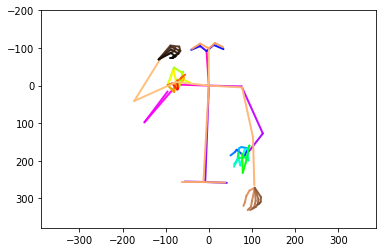

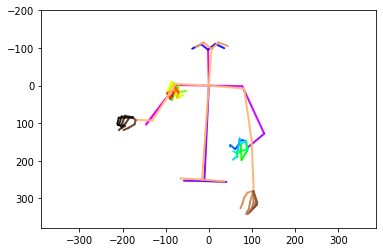

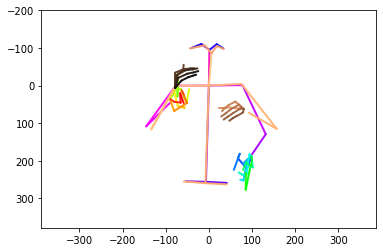

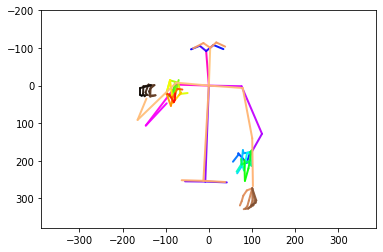

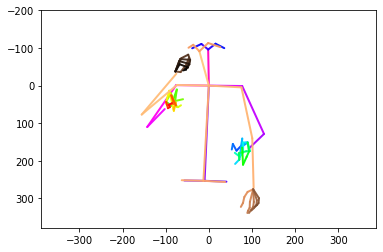

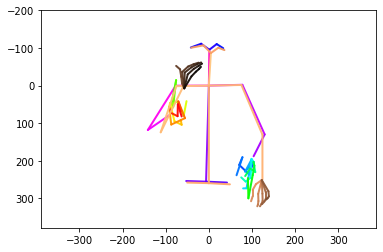

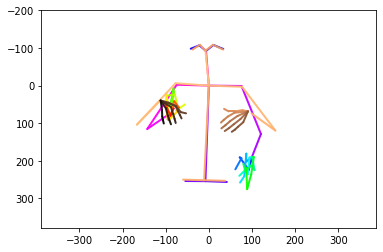

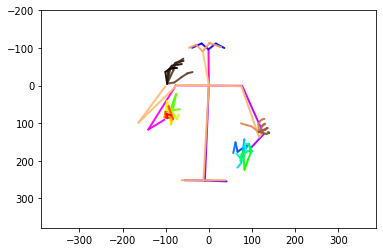

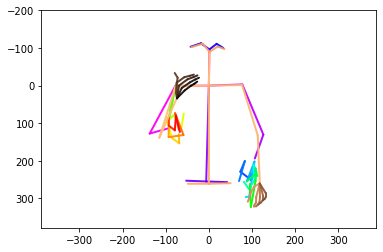

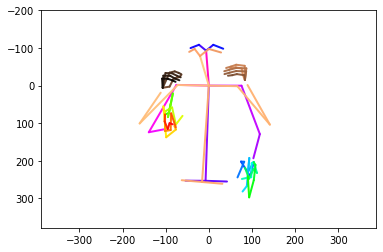

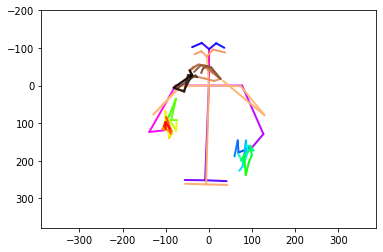

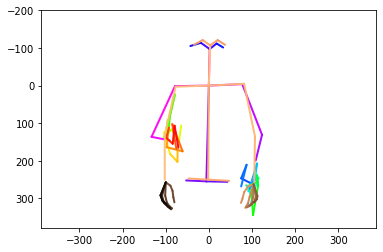

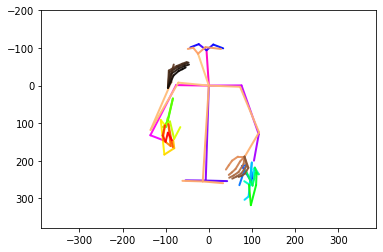

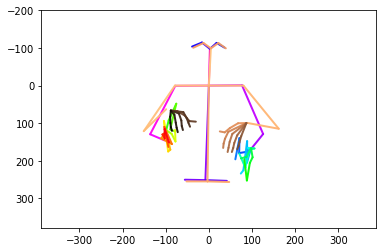

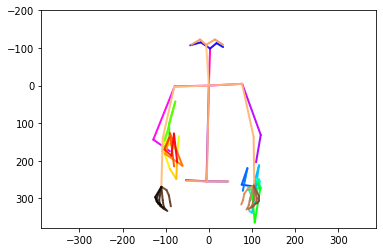

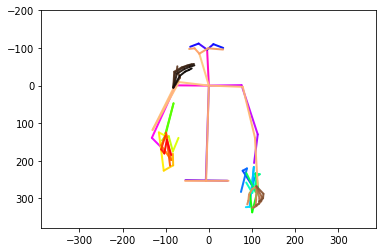

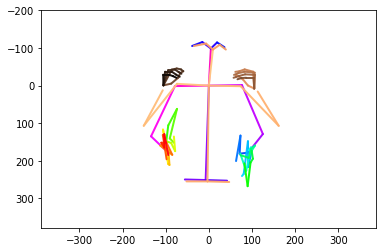

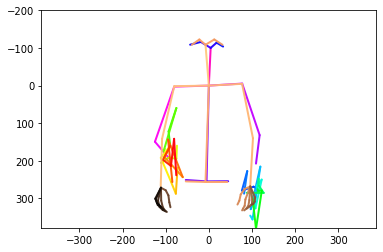

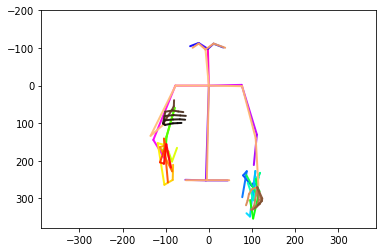

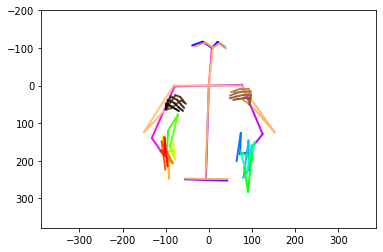

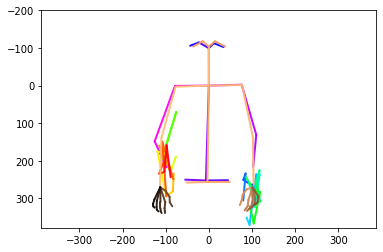

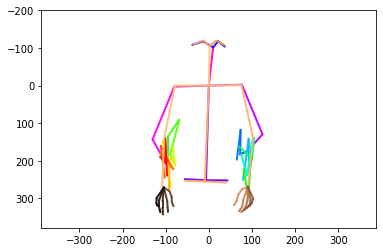

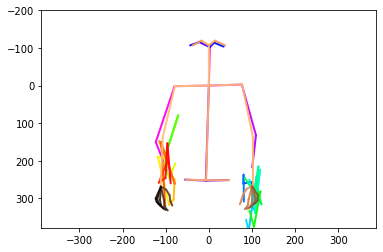

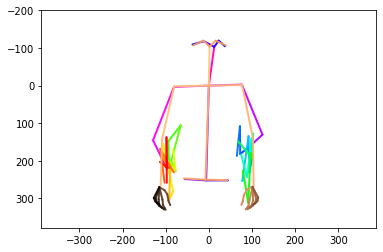

In [8]:
fig = plt.figure()

for i, pose in enumerate(vis_pose):
#     clear_output(wait=True)
    ax = plt.subplot(111)
    pose = skel.denormalize_pose(pose, test_dataset.mean, test_dataset.std)
    pose_gt = skel.denormalize_pose(vis_gt[i], test_dataset.mean, test_dataset.std)
#     print(pose.shape)
    skel.plot_pose2D(ax, pose)
    skel.plot_pose2D(ax, pose_gt, colormap='copper')
    plt.show()

In [9]:
print(pose_seq.view(pose_seq.shape[0], pose_seq.shape[1], -1)[:,0,...].shape)
print((pose_seq.view(pose_seq.shape[0], pose_seq.shape[1], -1).shape))
print(lang_embed.shape)

torch.Size([3, 114])
torch.Size([3, 14, 114])
torch.Size([3, 768])


In [10]:
lang_embed = torch.FloatTensor(language_encoder(transl_eng))
test_output = pose_decoder.sample(lang_embed, max(img_seq_len),\
                             pose_seq.view(pose_seq.shape[0], pose_seq.shape[1], -1)[:,0,...],\
                             attn=None)
print(test_output.shape)

torch.Size([3, 14, 114])


torch.Size([39, 57, 2])


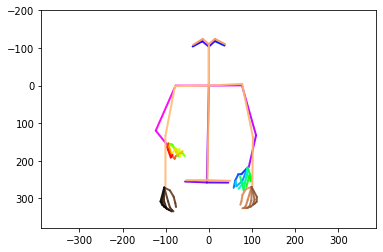

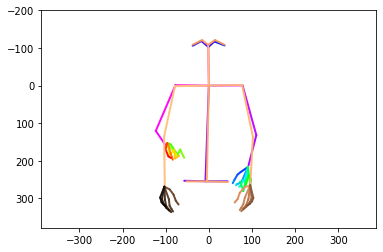

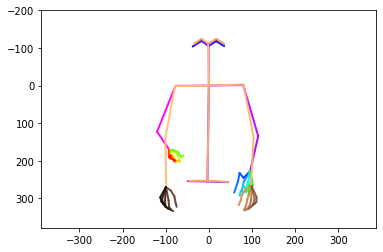

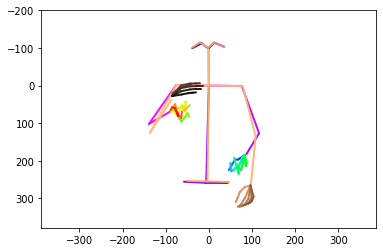

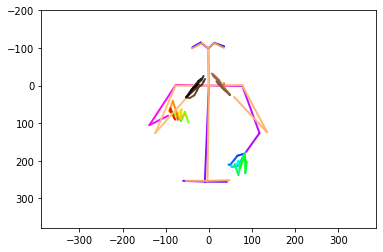

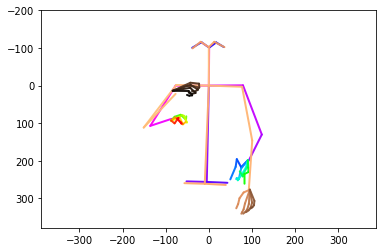

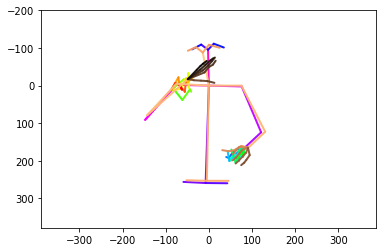

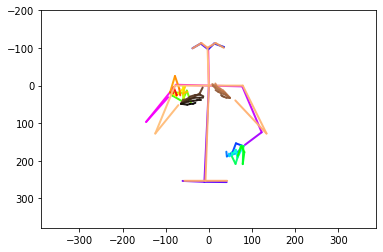

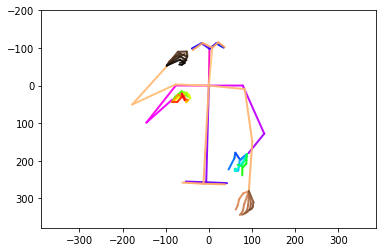

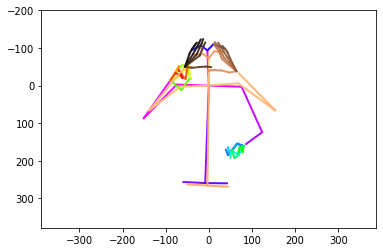

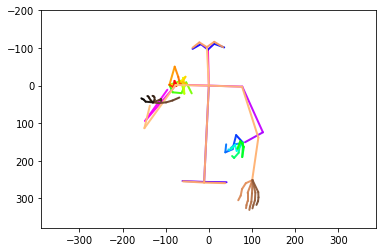

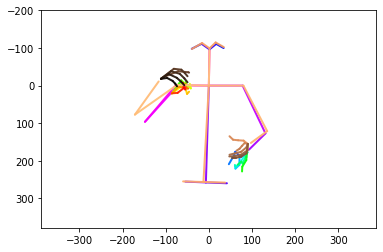

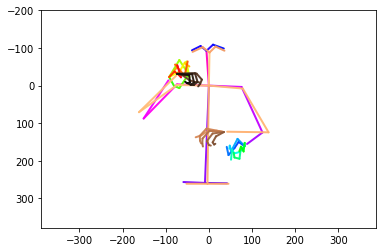

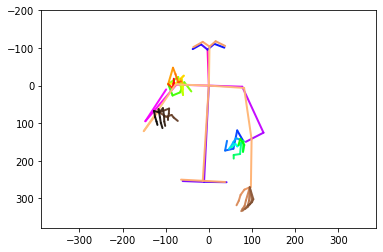

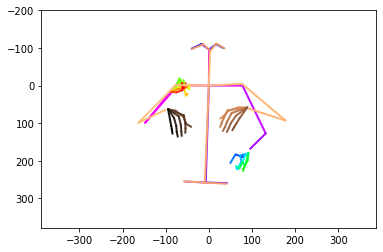

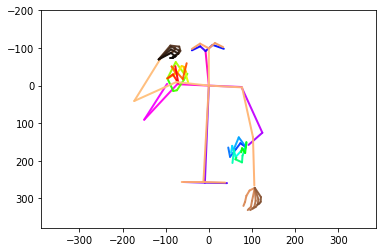

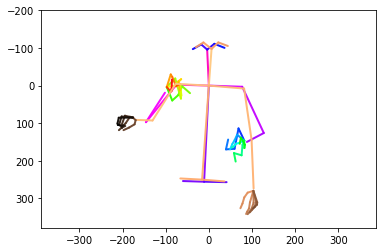

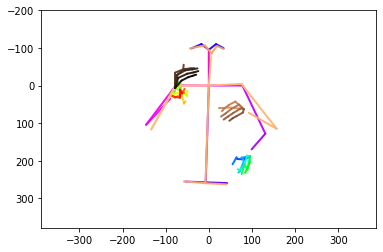

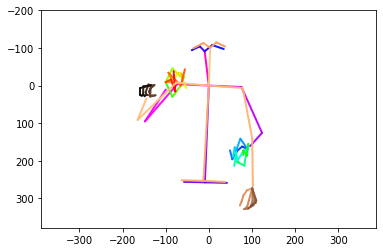

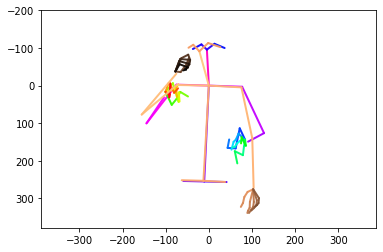

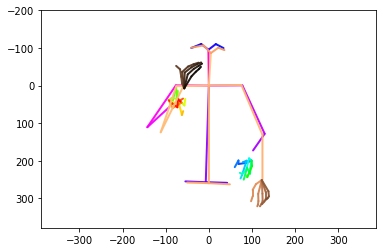

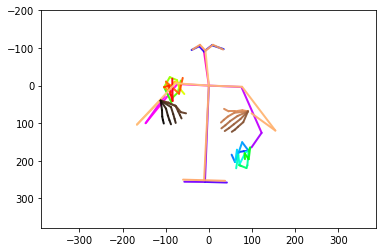

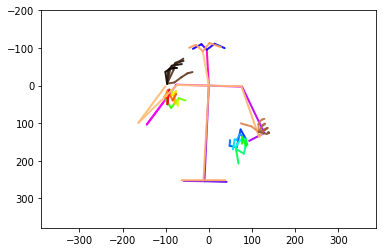

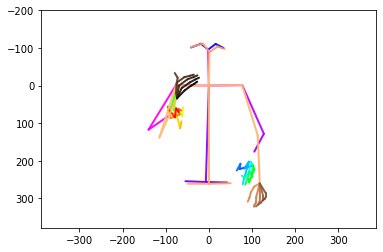

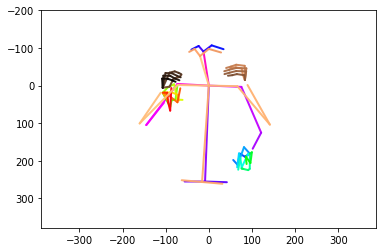

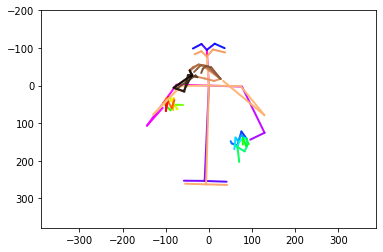

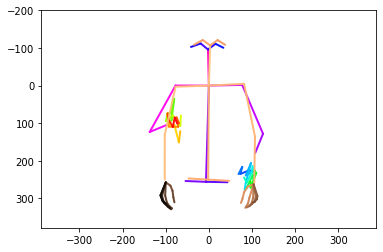

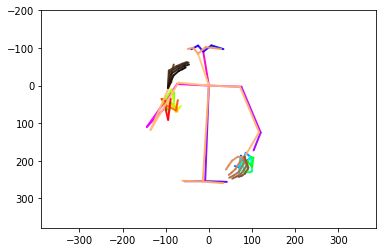

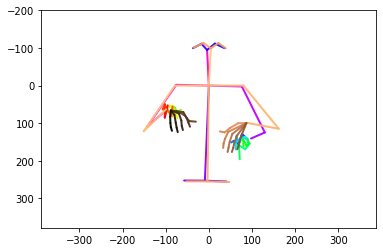

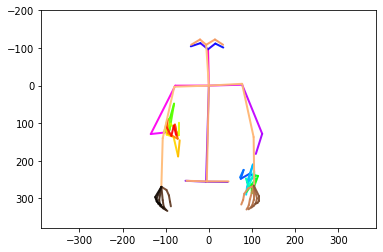

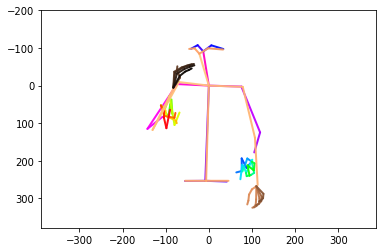

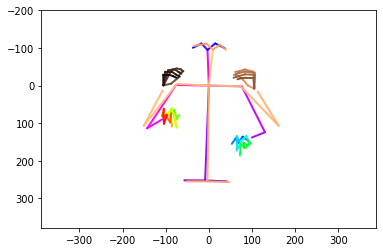

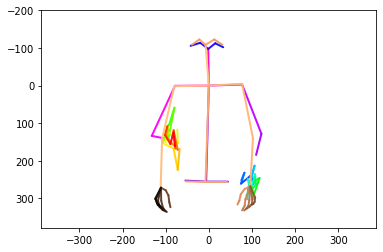

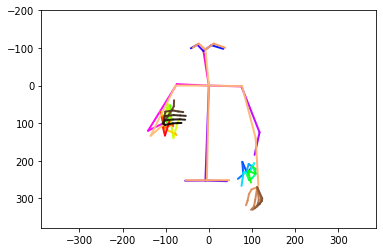

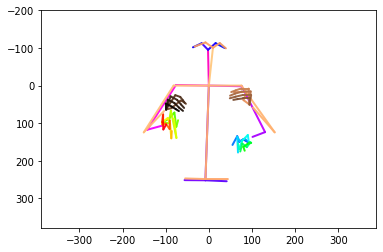

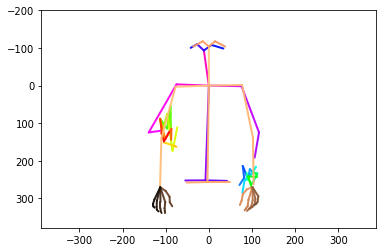

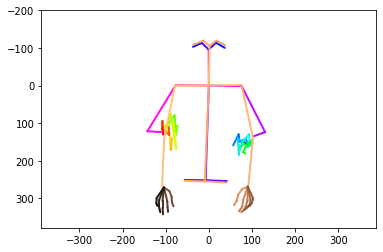

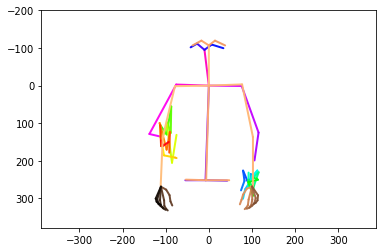

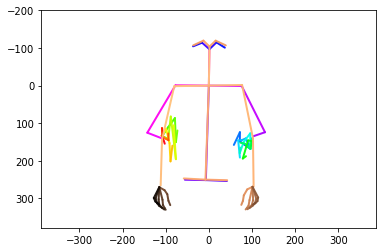

In [11]:
test_output = dataset.unpad_sequence(test_output, img_seq_len).data
vis_pose = test_output.view(test_output.shape[0], -1 , 2).detach()
print(vis_pose.shape)
for i, pose in enumerate(vis_pose):
#     clear_output(wait=True)
    ax = plt.subplot(111)
    pose = skel.denormalize_pose(pose, test_dataset.mean, test_dataset.std)
    pose_gt = skel.denormalize_pose(vis_gt[i], test_dataset.mean, test_dataset.std)
#     print(pose.shape)
    skel.plot_pose2D(ax, pose)
    skel.plot_pose2D(ax, pose_gt, colormap='copper')
    plt.show()

### Experiment with L1 Loss

In [12]:
language_encoder = model.language_encoder()
pose_encoder = model.Encoder()
pose_decoder = model.Decoder(hidden_size=768, pose_size=57*2, trajectory_size=0,
               use_h=False, start_zero=False, use_tp=False,
               use_lang=False, use_attn=False)

/scratch/abi/venv/ms/lib/python3.6/site-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [13]:
num_epochs = 50
loss_fn = torch.nn.L1Loss()
optimizerDecoder = torch.optim.SGD(pose_decoder.parameters(), lr=0.1)

In [14]:
for epoch in range(num_epochs):
    for i, data in enumerate(test_dataloader):
        if i == 1:
            break
        optimizerDecoder.zero_grad()
        
        img_seq = torch.FloatTensor(data['img_seq'])
        pose_seq = data['pose_seq']
        label_seq = data['label_seq']
        transl_eng = data['transl_eng']
        transl_deu = data['transl_deu']
        img_seq_len = data['seq_len']
        
        total_sequence = sum(np.array(img_seq_len))
        
        lang_embed = torch.FloatTensor(language_encoder(transl_eng))
#         print(img_seq_len)
#         print(pose_seq.shape)
#         print(label_seq.shape)

        output = pose_decoder(lang_embed, max(img_seq_len), pose_seq.view(pose_seq.shape[0], pose_seq.shape[1], -1),\
                              epoch=epoch)
#         print(output.shape)
#         print(np.array(img_seq_len)-1)
        pred_pose = dataset.unpad_sequence(output, img_seq_len).data
#         print(pred_pose.shape)

        gt_label = dataset.unpad_sequence(label_seq, np.array(img_seq_len)).data.view(-1, num_joints*joint_dim)
#         print(gt_label.shape)
#         print(gt_label[0])

#         mean = test_dataset.mean.unsqueeze(0).repeat(total_sequence, 1, 1)
#         std = test_dataset.std.unsqueeze(0).repeat(total_sequence, 1, 1)
#         denorm_output = skel.denormalize_pose(pred_pose.view(-1, 57, 2), mean, std)
#         denorm_label = skel.denormalize_pose(gt_label.view(-1, 57, 2), mean, std)

        loss = loss_fn(pred_pose, gt_label)
#         loss = loss_fn(denorm_output, denorm_label)
        loss.backward()
        optimizerDecoder.step()
        print(loss)

tensor(1.1929, grad_fn=<L1LossBackward>)
tensor(1.1930, grad_fn=<L1LossBackward>)
tensor(1.0819, grad_fn=<L1LossBackward>)
tensor(0.8656, grad_fn=<L1LossBackward>)
tensor(0.8219, grad_fn=<L1LossBackward>)
tensor(0.7819, grad_fn=<L1LossBackward>)
tensor(0.7708, grad_fn=<L1LossBackward>)
tensor(0.7614, grad_fn=<L1LossBackward>)
tensor(0.7669, grad_fn=<L1LossBackward>)
tensor(0.7658, grad_fn=<L1LossBackward>)
tensor(0.7727, grad_fn=<L1LossBackward>)
tensor(0.7530, grad_fn=<L1LossBackward>)
tensor(0.7507, grad_fn=<L1LossBackward>)
tensor(0.7477, grad_fn=<L1LossBackward>)
tensor(0.7411, grad_fn=<L1LossBackward>)
tensor(0.7301, grad_fn=<L1LossBackward>)
tensor(0.7263, grad_fn=<L1LossBackward>)
tensor(0.7269, grad_fn=<L1LossBackward>)
tensor(0.7259, grad_fn=<L1LossBackward>)
tensor(0.7257, grad_fn=<L1LossBackward>)
tensor(0.7248, grad_fn=<L1LossBackward>)
tensor(0.7270, grad_fn=<L1LossBackward>)
tensor(0.7275, grad_fn=<L1LossBackward>)
tensor(0.7282, grad_fn=<L1LossBackward>)
tensor(0.7206, g

In [15]:
vis_pose = pred_pose.view(pred_pose.shape[0], -1 , 2).detach()
vis_gt = gt_label.view(pred_pose.shape[0], -1 , 2).detach()

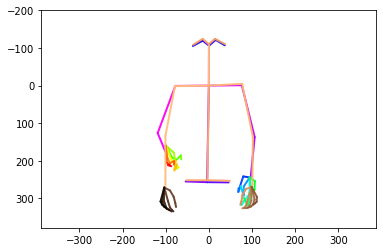

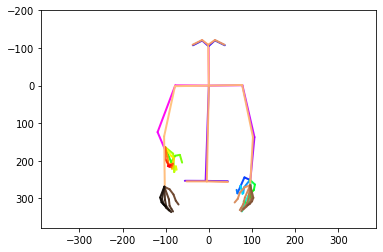

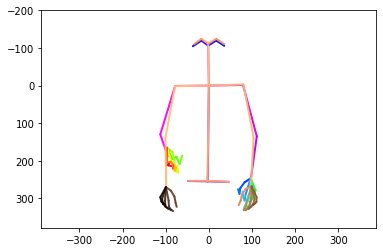

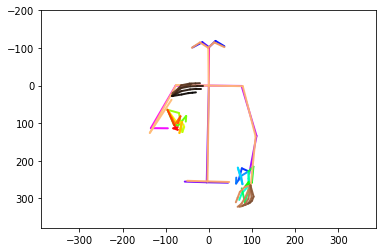

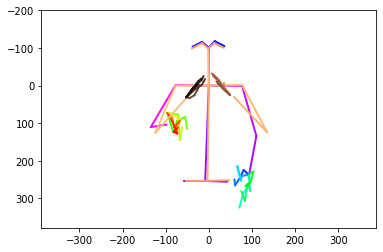

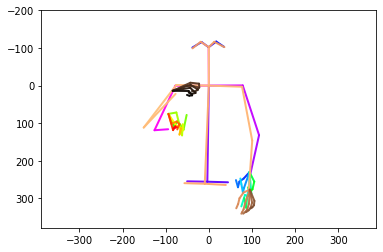

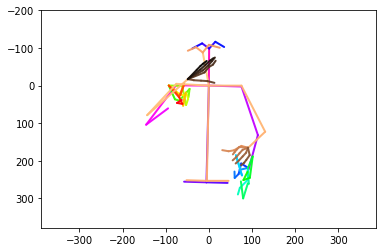

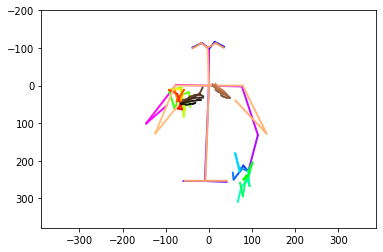

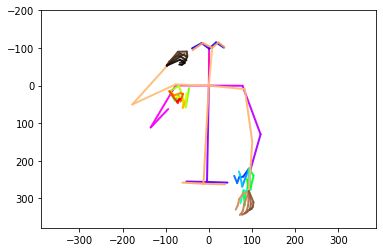

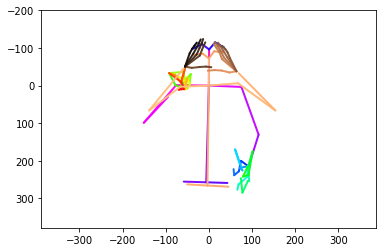

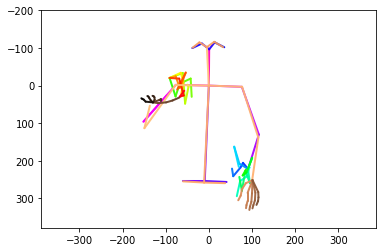

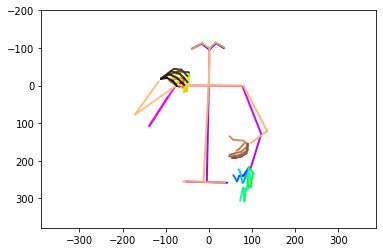

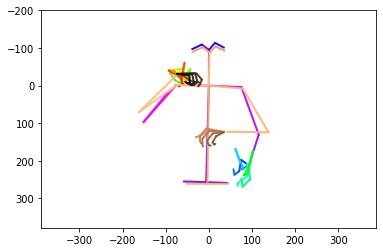

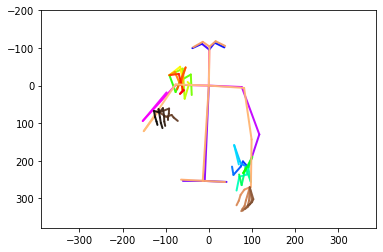

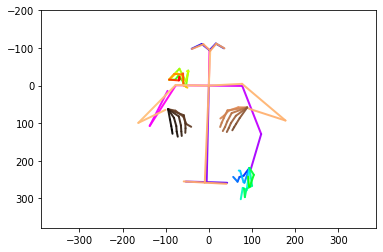

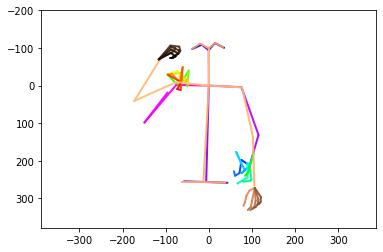

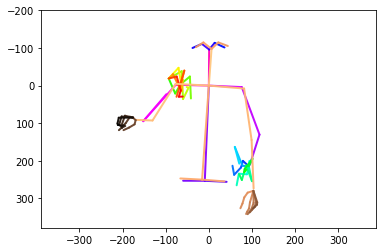

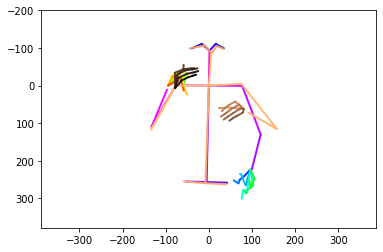

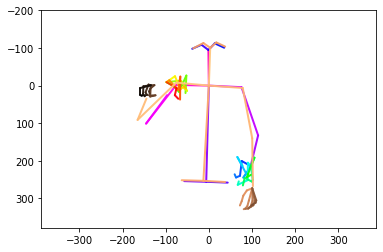

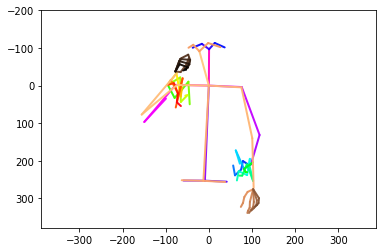

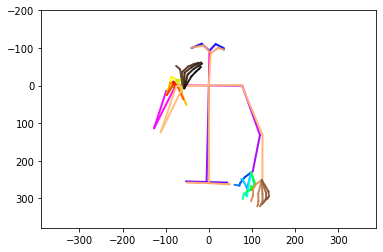

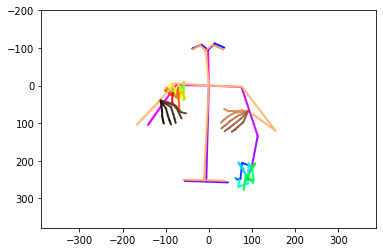

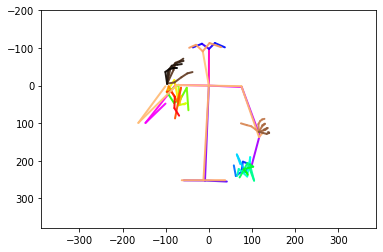

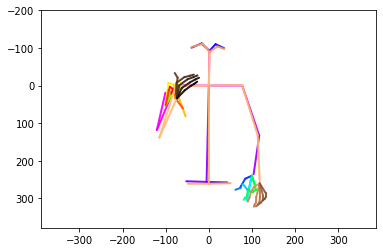

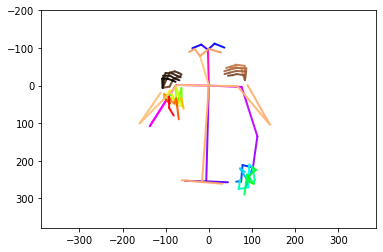

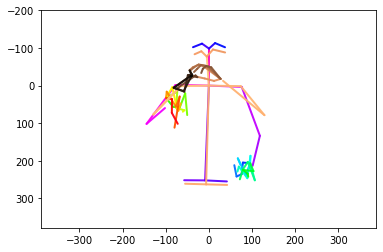

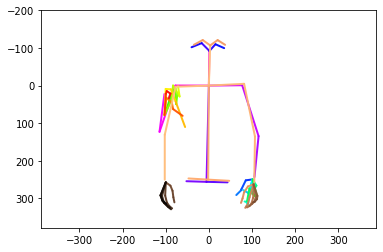

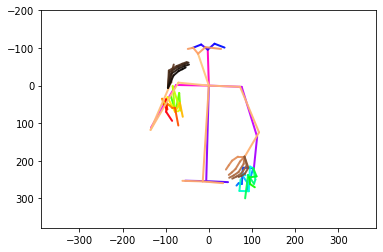

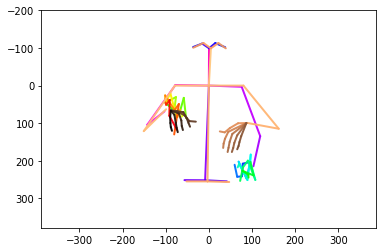

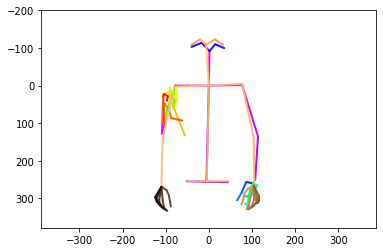

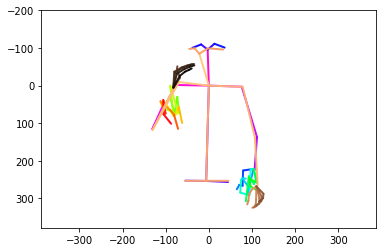

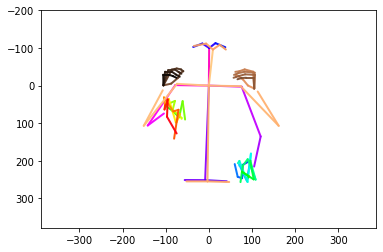

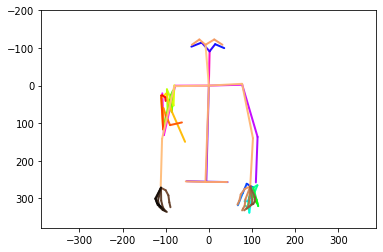

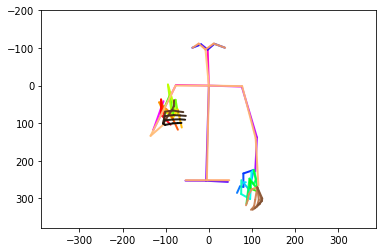

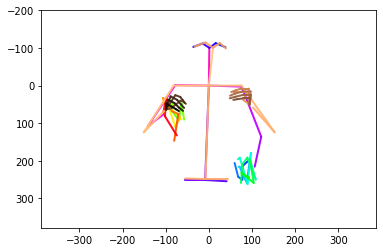

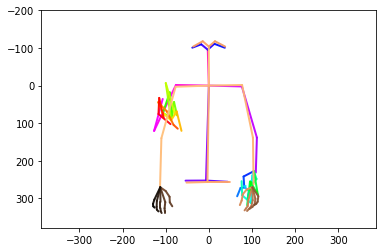

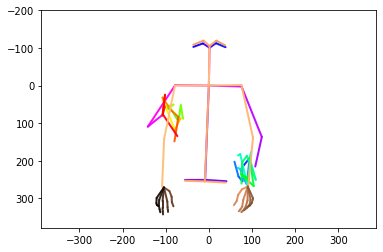

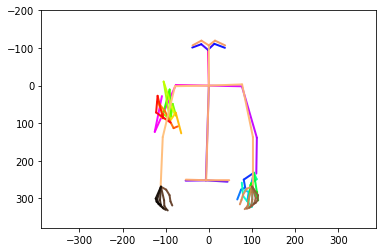

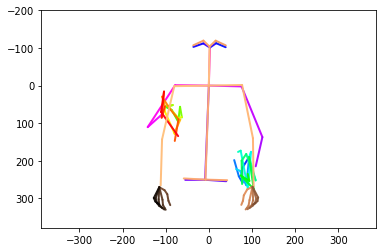

In [16]:
fig = plt.figure()

for i, pose in enumerate(vis_pose):
#     clear_output(wait=True)
    ax = plt.subplot(111)
    pose = skel.denormalize_pose(pose, test_dataset.mean, test_dataset.std)
    pose_gt = skel.denormalize_pose(vis_gt[i], test_dataset.mean, test_dataset.std)
#     print(pose.shape)
    skel.plot_pose2D(ax, pose)
    skel.plot_pose2D(ax, pose_gt, colormap='copper')
    plt.show()

torch.Size([39, 57, 2])


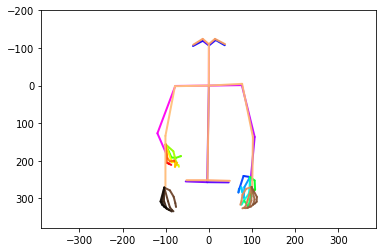

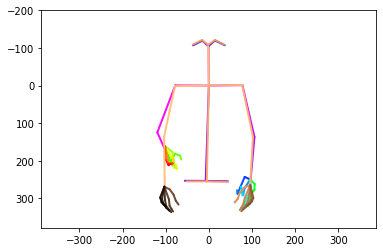

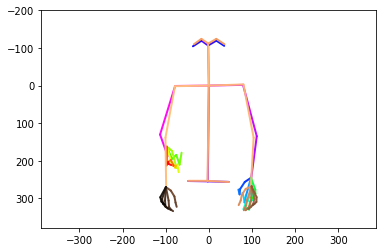

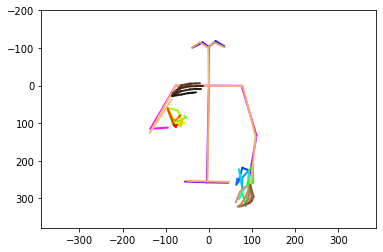

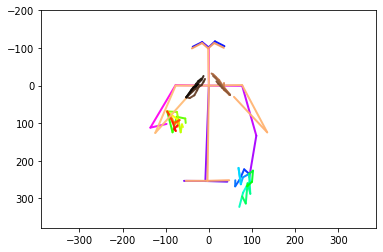

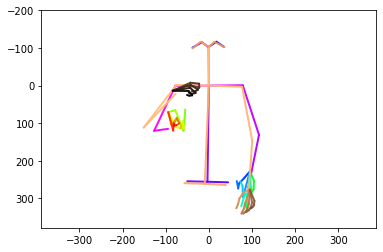

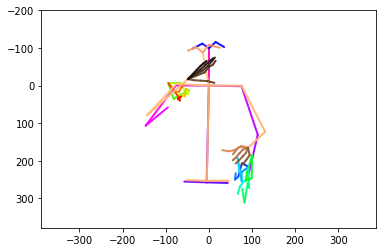

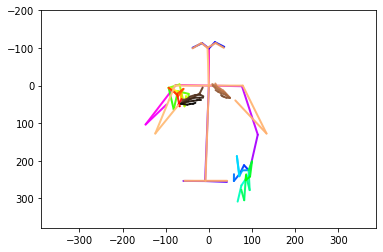

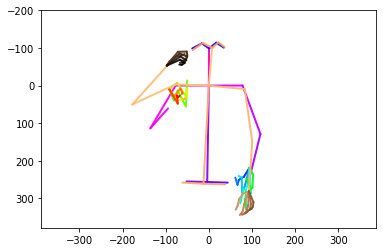

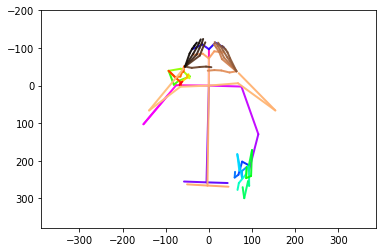

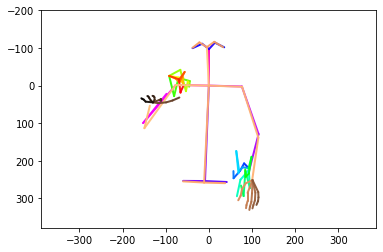

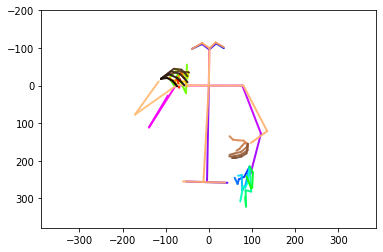

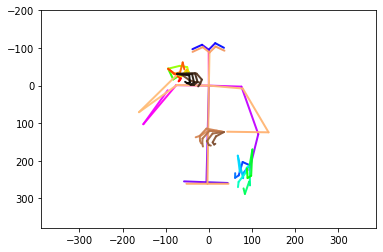

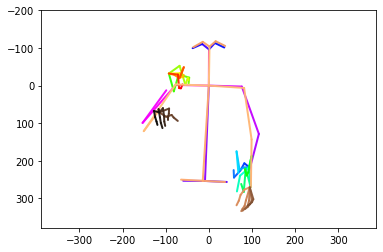

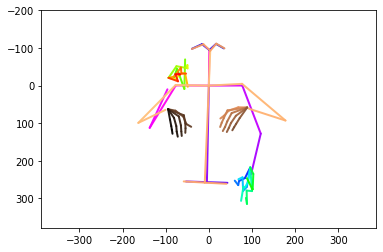

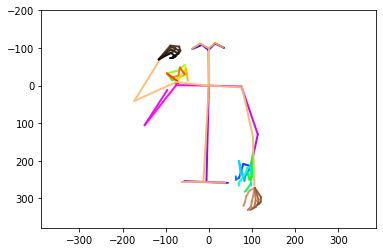

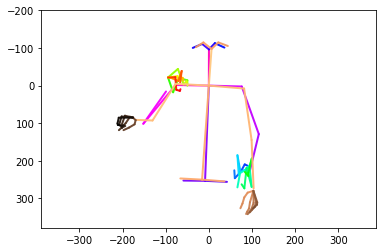

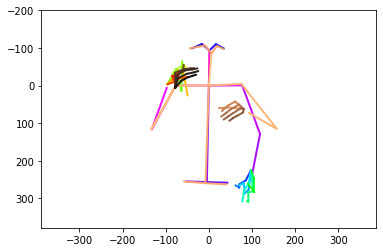

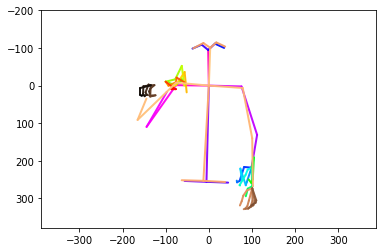

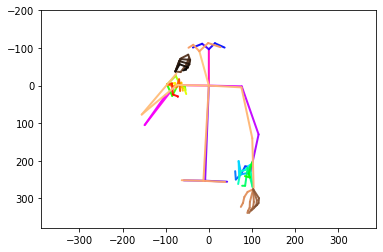

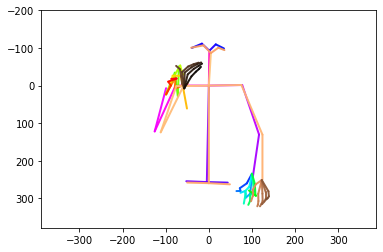

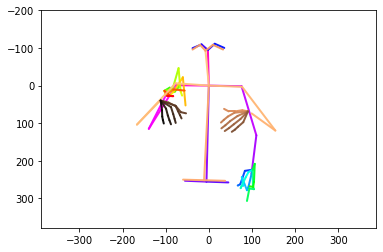

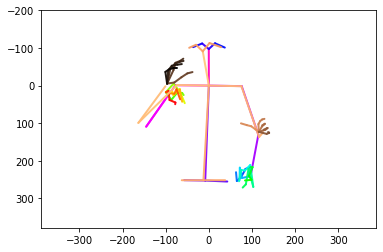

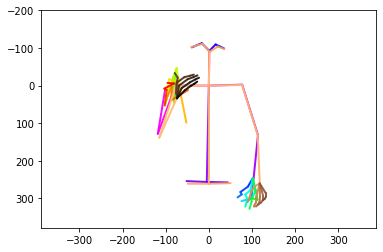

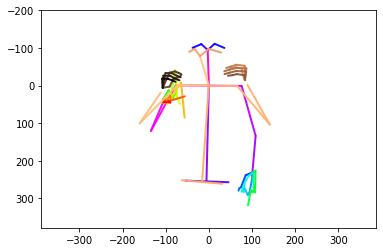

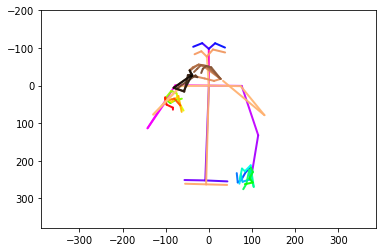

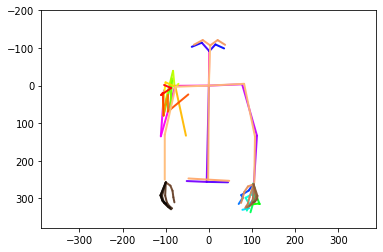

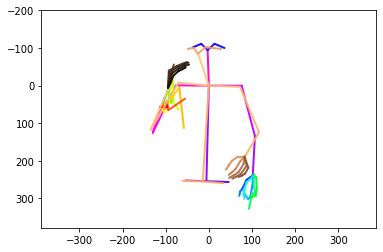

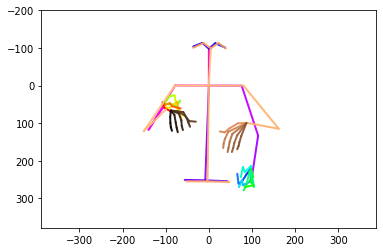

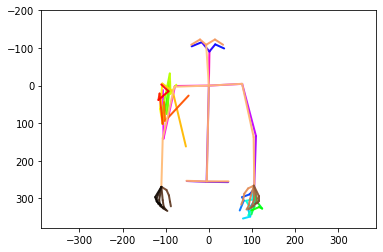

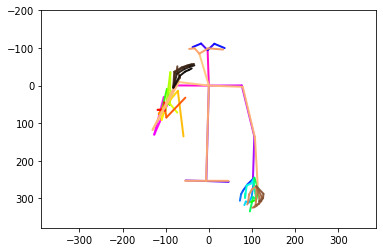

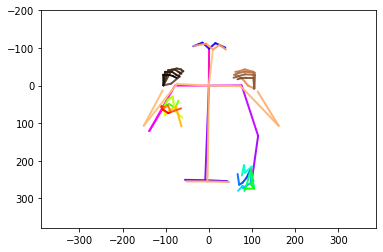

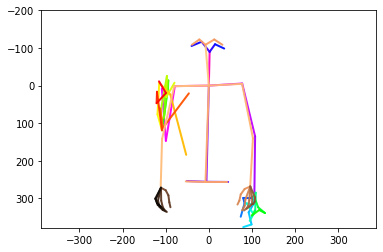

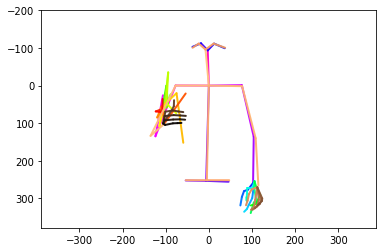

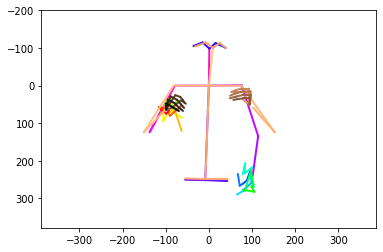

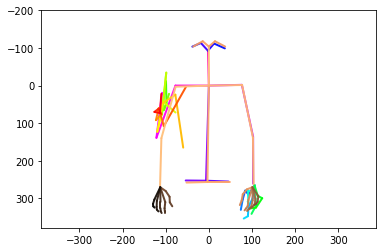

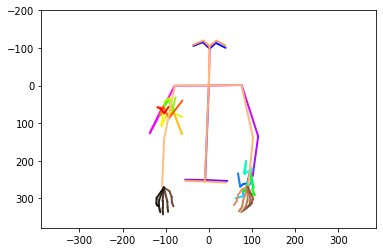

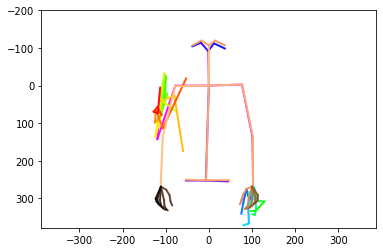

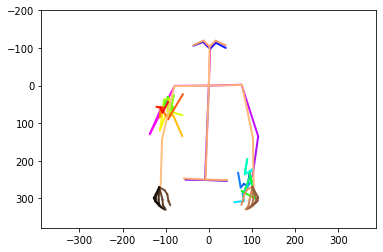

In [17]:
lang_embed = torch.FloatTensor(language_encoder(transl_eng))
test_output = pose_decoder.sample(lang_embed, max(img_seq_len),\
                             pose_seq.view(pose_seq.shape[0], pose_seq.shape[1], -1)[:,0,...],\
                             attn=None)
test_output = dataset.unpad_sequence(test_output, img_seq_len).data
vis_pose = test_output.view(test_output.shape[0], -1 , 2).detach()
print(vis_pose.shape)
for i, pose in enumerate(vis_pose):
#     clear_output(wait=True)
    ax = plt.subplot(111)
    pose = skel.denormalize_pose(pose, test_dataset.mean, test_dataset.std)
    pose_gt = skel.denormalize_pose(vis_gt[i], test_dataset.mean, test_dataset.std)
#     print(pose.shape)
    skel.plot_pose2D(ax, pose)
    skel.plot_pose2D(ax, pose_gt, colormap='copper')
    plt.show()

### Experiment Freezing BERT Encoder

In [18]:
language_encoder = model.language_encoder()
pose_encoder = model.Encoder()
pose_decoder = model.Decoder(hidden_size=768, pose_size=57*2, trajectory_size=0,
               use_h=False, start_zero=False, use_tp=False,
               use_lang=False, use_attn=False)

/scratch/abi/venv/ms/lib/python3.6/site-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [19]:
for param in language_encoder.parameters():
    param.requires_grad = False

In [20]:
num_epochs = 50
loss_fn = torch.nn.L1Loss()
optimizerDecoder = torch.optim.SGD(pose_decoder.parameters(), lr=0.1)

In [21]:
for epoch in range(num_epochs):
    for i, data in enumerate(test_dataloader):
        if i == 1:
            break
        optimizerDecoder.zero_grad()
        
        img_seq = torch.FloatTensor(data['img_seq'])
        pose_seq = data['pose_seq']
        label_seq = data['label_seq']
        transl_eng = data['transl_eng']
        transl_deu = data['transl_deu']
        img_seq_len = data['seq_len']
        
        total_sequence = sum(np.array(img_seq_len))
        
        lang_embed = torch.FloatTensor(language_encoder(transl_eng))
#         print(img_seq_len)
#         print(pose_seq.shape)
#         print(label_seq.shape)

        output = pose_decoder(lang_embed, max(img_seq_len), pose_seq.view(pose_seq.shape[0], pose_seq.shape[1], -1),\
                              epoch=epoch)
#         print(output.shape)
#         print(np.array(img_seq_len)-1)
        pred_pose = dataset.unpad_sequence(output, img_seq_len).data
#         print(pred_pose.shape)

        gt_label = dataset.unpad_sequence(label_seq, np.array(img_seq_len)).data.view(-1, num_joints*joint_dim)
#         print(gt_label.shape)
#         print(gt_label[0])

#         mean = test_dataset.mean.unsqueeze(0).repeat(total_sequence, 1, 1)
#         std = test_dataset.std.unsqueeze(0).repeat(total_sequence, 1, 1)
#         denorm_output = skel.denormalize_pose(pred_pose.view(-1, 57, 2), mean, std)
#         denorm_label = skel.denormalize_pose(gt_label.view(-1, 57, 2), mean, std)

        loss = loss_fn(pred_pose, gt_label)
#         loss = loss_fn(denorm_output, denorm_label)
        loss.backward()
        optimizerDecoder.step()
        print(loss)

tensor(1.1958, grad_fn=<L1LossBackward>)
tensor(1.2119, grad_fn=<L1LossBackward>)
tensor(1.1024, grad_fn=<L1LossBackward>)
tensor(0.8778, grad_fn=<L1LossBackward>)
tensor(0.8090, grad_fn=<L1LossBackward>)
tensor(0.7912, grad_fn=<L1LossBackward>)
tensor(0.7779, grad_fn=<L1LossBackward>)
tensor(0.7675, grad_fn=<L1LossBackward>)
tensor(0.7687, grad_fn=<L1LossBackward>)
tensor(0.7738, grad_fn=<L1LossBackward>)
tensor(0.7969, grad_fn=<L1LossBackward>)
tensor(0.7641, grad_fn=<L1LossBackward>)
tensor(0.7501, grad_fn=<L1LossBackward>)
tensor(0.7409, grad_fn=<L1LossBackward>)
tensor(0.7310, grad_fn=<L1LossBackward>)
tensor(0.7370, grad_fn=<L1LossBackward>)
tensor(0.7324, grad_fn=<L1LossBackward>)
tensor(0.7333, grad_fn=<L1LossBackward>)
tensor(0.7315, grad_fn=<L1LossBackward>)
tensor(0.7478, grad_fn=<L1LossBackward>)
tensor(0.7369, grad_fn=<L1LossBackward>)
tensor(0.7255, grad_fn=<L1LossBackward>)
tensor(0.7181, grad_fn=<L1LossBackward>)
tensor(0.7127, grad_fn=<L1LossBackward>)
tensor(0.7106, g

In [22]:
vis_pose = pred_pose.view(pred_pose.shape[0], -1 , 2).detach()
vis_gt = gt_label.view(pred_pose.shape[0], -1 , 2).detach()

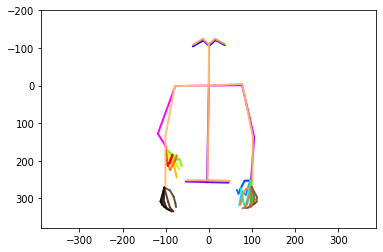

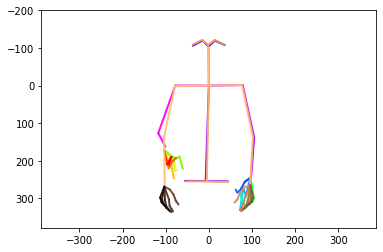

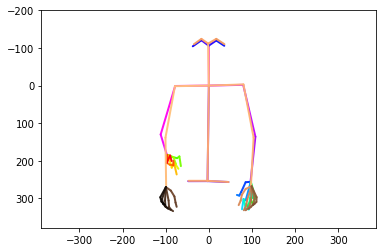

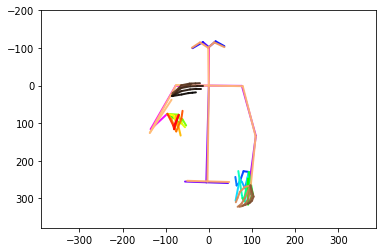

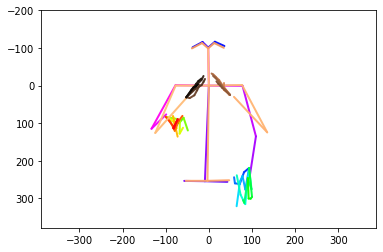

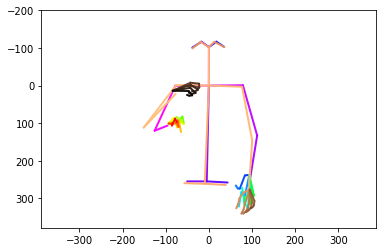

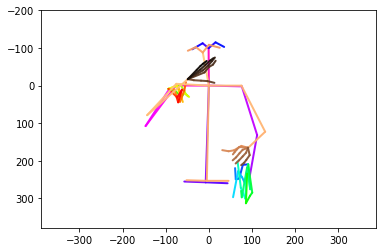

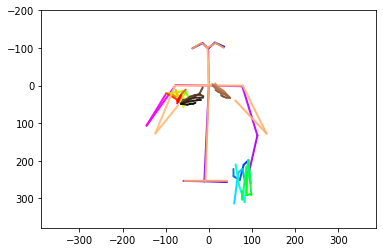

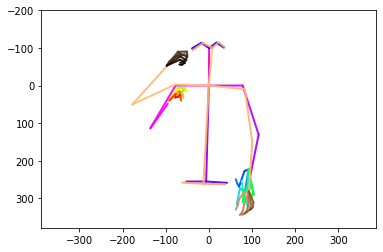

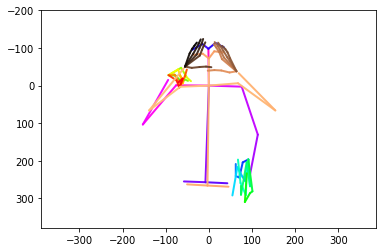

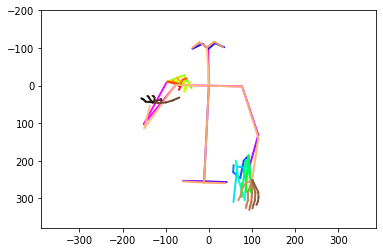

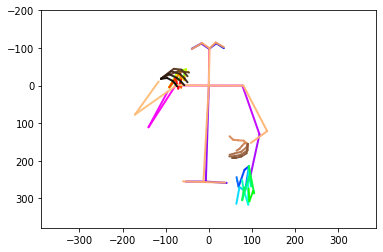

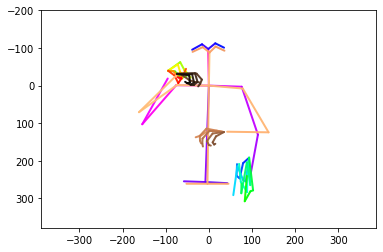

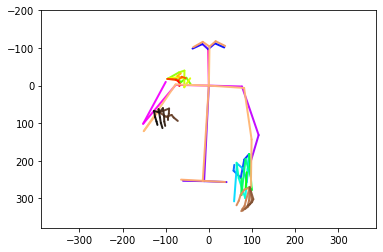

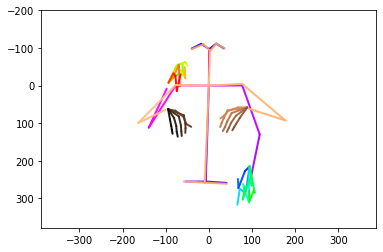

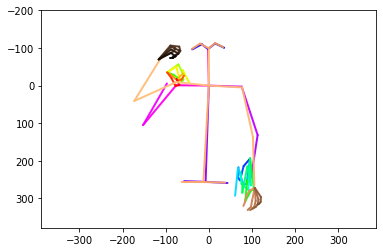

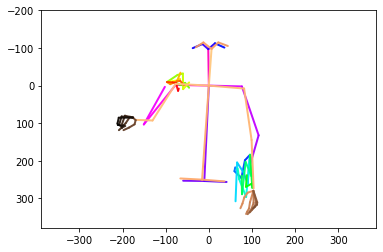

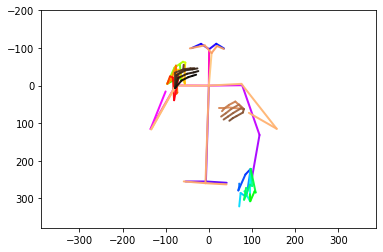

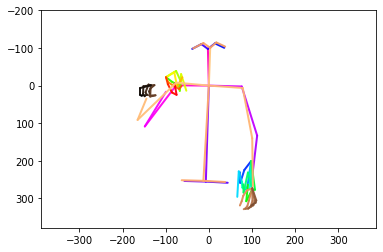

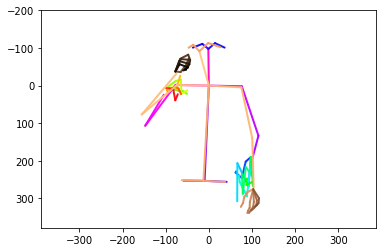

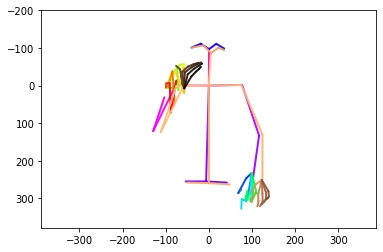

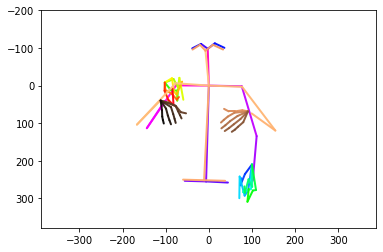

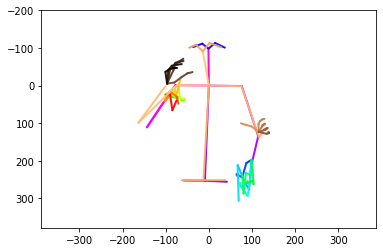

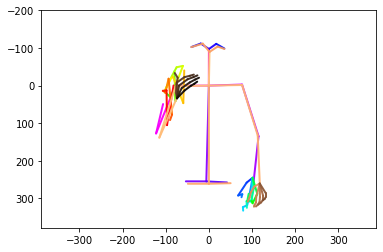

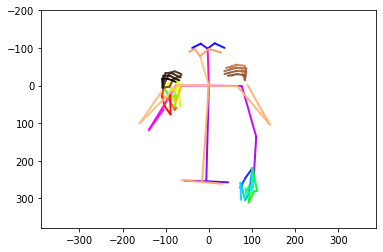

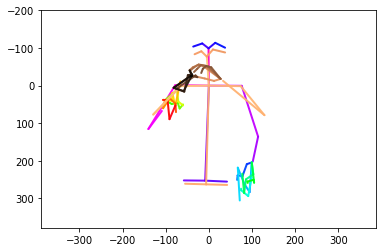

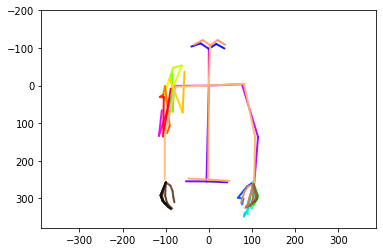

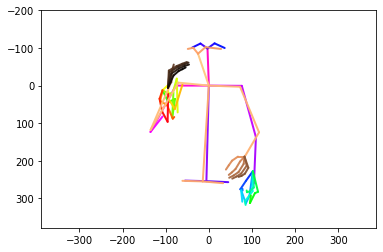

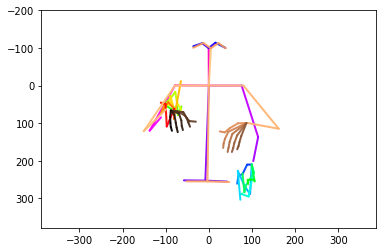

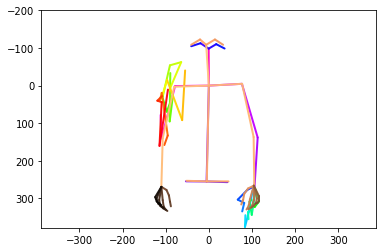

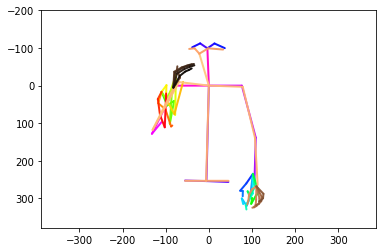

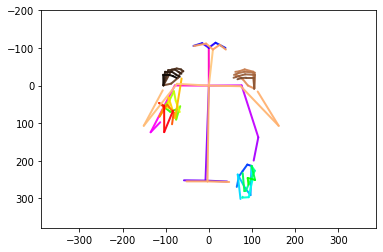

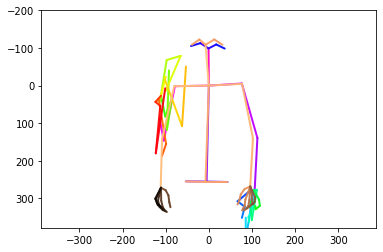

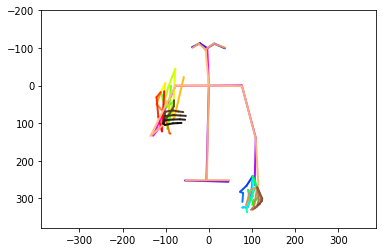

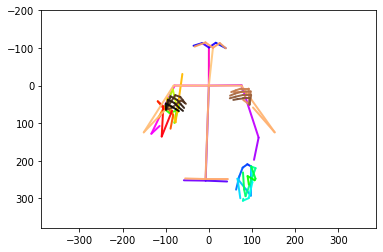

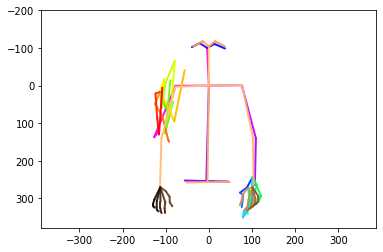

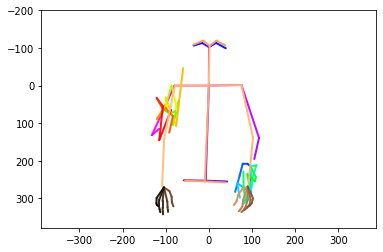

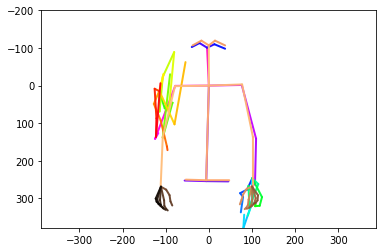

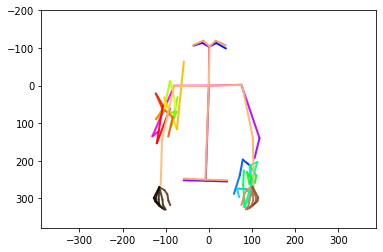

In [23]:
fig = plt.figure()

for i, pose in enumerate(vis_pose):
#     clear_output(wait=True)
    ax = plt.subplot(111)
    pose = skel.denormalize_pose(pose, test_dataset.mean, test_dataset.std)
    pose_gt = skel.denormalize_pose(vis_gt[i], test_dataset.mean, test_dataset.std)
#     print(pose.shape)
    skel.plot_pose2D(ax, pose)
    skel.plot_pose2D(ax, pose_gt, colormap='copper')
    plt.show()

torch.Size([39, 57, 2])


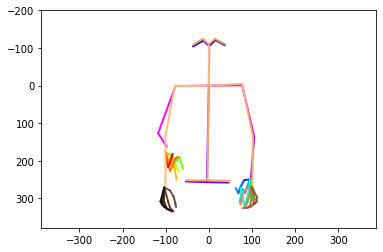

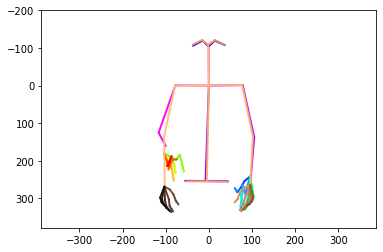

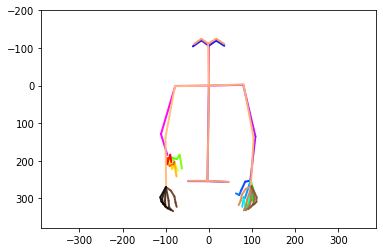

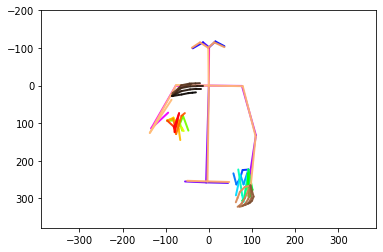

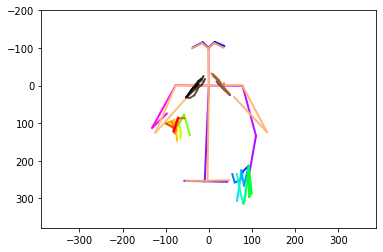

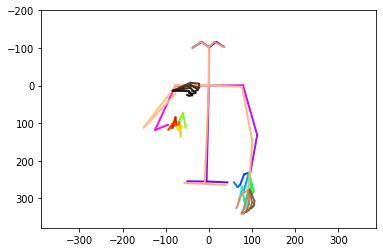

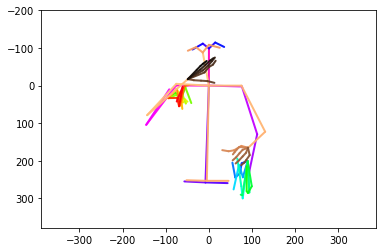

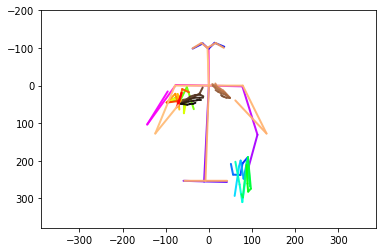

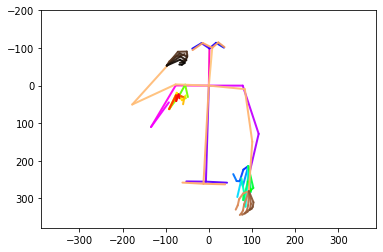

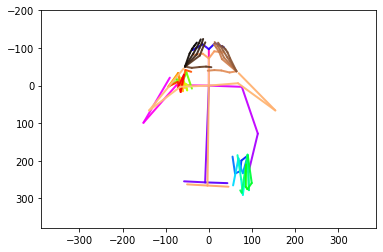

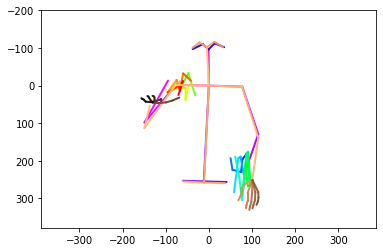

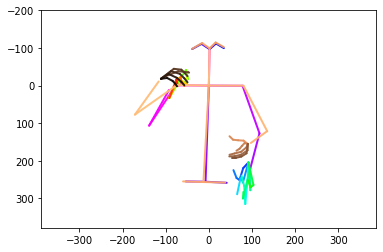

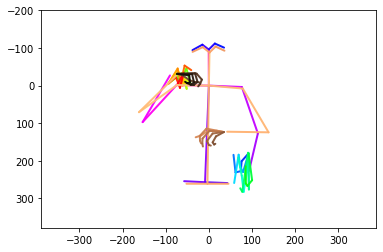

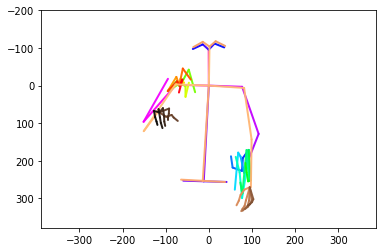

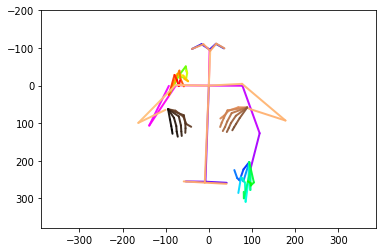

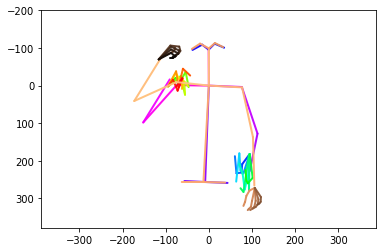

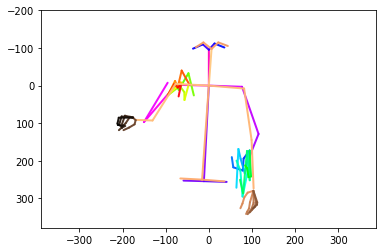

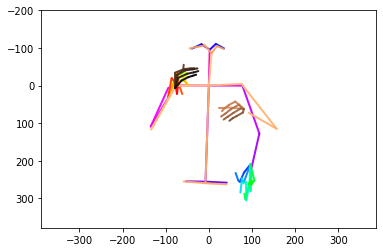

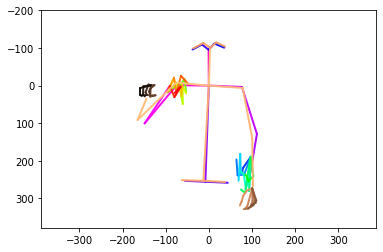

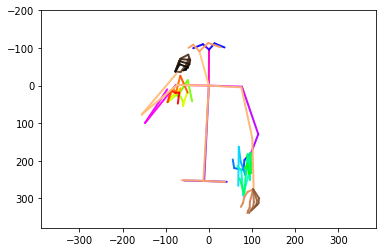

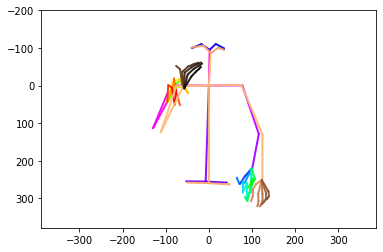

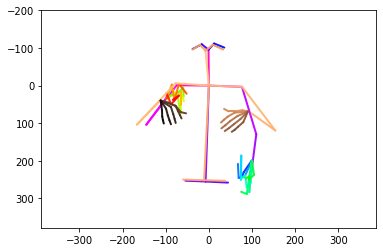

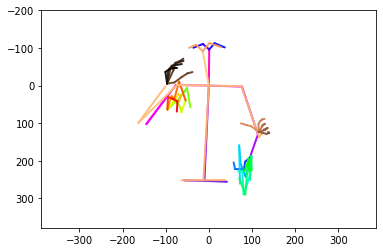

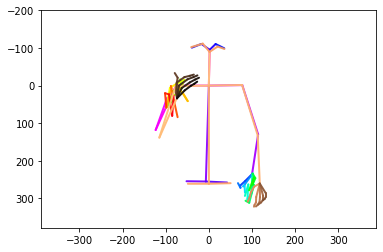

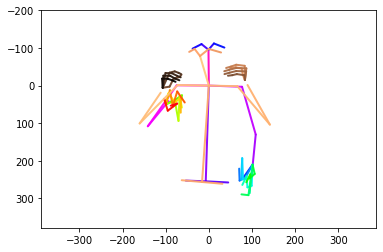

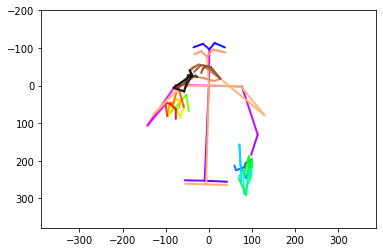

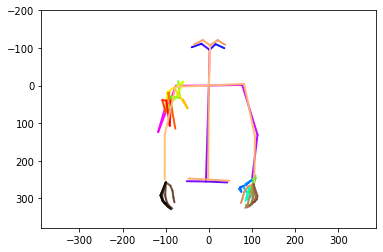

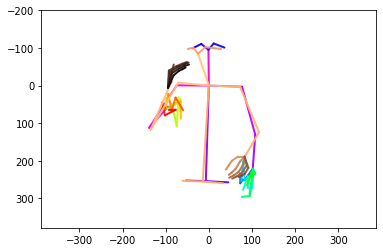

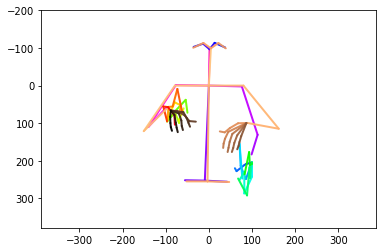

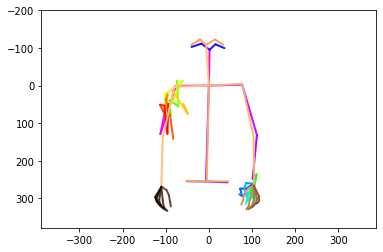

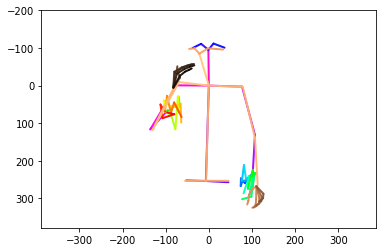

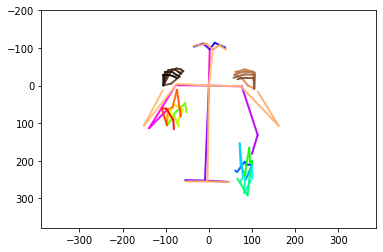

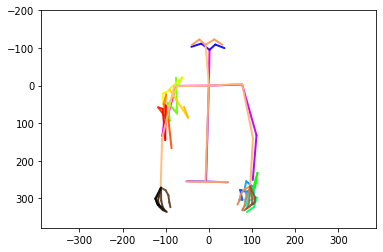

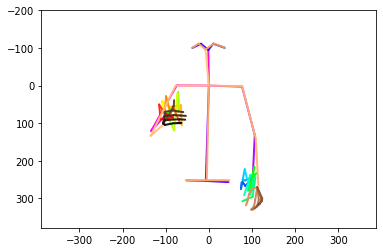

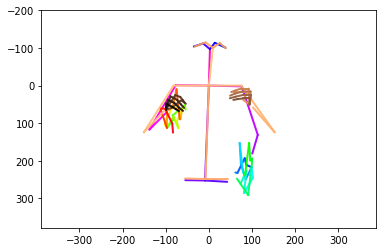

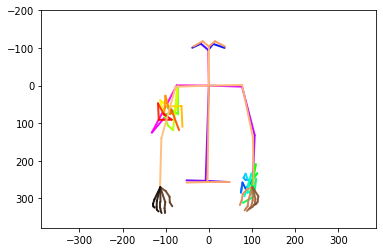

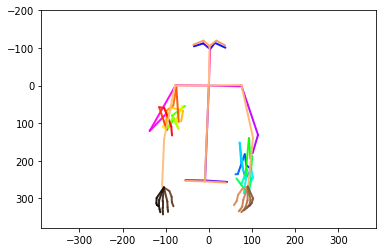

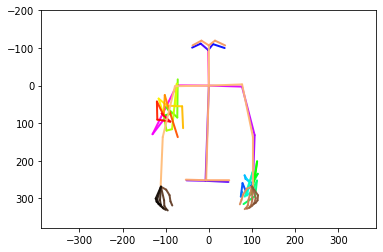

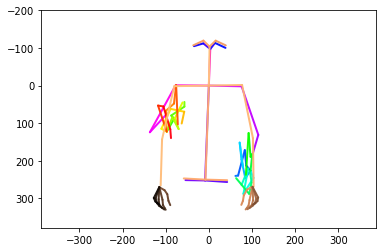

In [24]:
lang_embed = torch.FloatTensor(language_encoder(transl_eng))
test_output = pose_decoder.sample(lang_embed, max(img_seq_len),\
                             pose_seq.view(pose_seq.shape[0], pose_seq.shape[1], -1)[:,0,...],\
                             attn=None)
test_output = dataset.unpad_sequence(test_output, img_seq_len).data
vis_pose = test_output.view(test_output.shape[0], -1 , 2).detach()
print(vis_pose.shape)
for i, pose in enumerate(vis_pose):
#     clear_output(wait=True)
    ax = plt.subplot(111)
    pose = skel.denormalize_pose(pose, test_dataset.mean, test_dataset.std)
    pose_gt = skel.denormalize_pose(vis_gt[i], test_dataset.mean, test_dataset.std)
#     print(pose.shape)
    skel.plot_pose2D(ax, pose)
    skel.plot_pose2D(ax, pose_gt, colormap='copper')
    plt.show()

### Above + Difference Prediction

In [44]:
test_dataset = SIGNUMDataset('/scratch/datasets/SIGNUM', use_pose=True, subsample=3)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4, collate_fn=test_dataset.collate)

In [45]:
language_encoder = model.language_encoder()

pose_decoder = model.Decoder(hidden_size=768, pose_size=57*2, trajectory_size=0,
               use_h=False, start_zero=False, use_tp=False,
               use_lang=False, use_attn=False).to('cuda:0')

for param in language_encoder.parameters():
    param.requires_grad = False

In [46]:
num_joints = 57
joint_dim = 2
num_epochs = 100
loss_fn = torch.nn.L1Loss()
optimizerDecoder = torch.optim.SGD(pose_decoder.parameters(), lr=0.05)

In [47]:
for epoch in range(num_epochs):
    for i, data in enumerate(test_dataloader):
        if i == 1:
            break
        optimizerDecoder.zero_grad()
        
        img_seq = torch.FloatTensor(data['img_seq'])
        pose_seq = data['pose_seq'].cuda()
        label_seq = data['label_seq'].cuda()
        transl_eng = data['transl_eng']
        transl_deu = data['transl_deu']
        img_seq_len = data['seq_len']
        
        total_sequence = sum(np.array(img_seq_len))
        
        lang_embed = torch.FloatTensor(language_encoder(transl_eng)).cuda()

        output = pose_decoder(lang_embed, max(img_seq_len), pose_seq.view(pose_seq.shape[0], pose_seq.shape[1], -1),\
                              epoch=epoch)
#         print(output.shape)
#         print(np.array(img_seq_len)-1)
        pred_pose = dataset.unpad_sequence(output, img_seq_len).data
#         print(pred_pose.shape)

#         gt_label = dataset.unpad_sequence(label_seq, np.array(img_seq_len)).data.view(-1, num_joints*joint_dim)
        
        delta = label_seq - pose_seq
        gt_label = dataset.unpad_sequence(delta, np.array(img_seq_len)).data.view(-1, num_joints*joint_dim)
        
        loss = loss_fn(pred_pose, gt_label)
#         loss = loss_fn(denorm_output, denorm_label)
        loss.backward()
        optimizerDecoder.step()
        print(epoch, loss)

0 tensor(0.9019, device='cuda:0', grad_fn=<L1LossBackward>)
1 tensor(3.0806, device='cuda:0', grad_fn=<L1LossBackward>)
2 tensor(4.7197, device='cuda:0', grad_fn=<L1LossBackward>)
3 tensor(2.9313, device='cuda:0', grad_fn=<L1LossBackward>)
4 tensor(3.1079, device='cuda:0', grad_fn=<L1LossBackward>)
5 tensor(3.9540, device='cuda:0', grad_fn=<L1LossBackward>)
6 tensor(3.7737, device='cuda:0', grad_fn=<L1LossBackward>)
7 tensor(1.8351, device='cuda:0', grad_fn=<L1LossBackward>)
8 tensor(2.1492, device='cuda:0', grad_fn=<L1LossBackward>)
9 tensor(2.8377, device='cuda:0', grad_fn=<L1LossBackward>)
10 tensor(2.0446, device='cuda:0', grad_fn=<L1LossBackward>)
11 tensor(2.5825, device='cuda:0', grad_fn=<L1LossBackward>)
12 tensor(1.5947, device='cuda:0', grad_fn=<L1LossBackward>)
13 tensor(2.0799, device='cuda:0', grad_fn=<L1LossBackward>)
14 tensor(2.4633, device='cuda:0', grad_fn=<L1LossBackward>)
15 tensor(1.7551, device='cuda:0', grad_fn=<L1LossBackward>)
16 tensor(1.3654, device='cuda:0',

In [48]:
first_pose = pose_seq[:,0,:].cpu()
print(first_pose.shape)
vis_pose = pred_pose.view(pred_pose.shape[0], -1 , 2).cpu().detach() + pose_seq.squeeze(0).cpu()


gt_label = dataset.unpad_sequence(label_seq, np.array(img_seq_len)).data.view(-1, num_joints*joint_dim)
vis_gt = gt_label.view(pred_pose.shape[0], -1 , 2).cpu().detach()
print(vis_gt.shape)

mpjpe = skel.calculate_batch_mpjpe(skel.denormalize_pose(vis_pose, test_dataset.mean, test_dataset.std),
                                   skel.denormalize_pose(vis_gt, test_dataset.mean, test_dataset.std))
print(mpjpe)

torch.Size([1, 57, 2])
torch.Size([39, 57, 2])
tensor(22.6720)


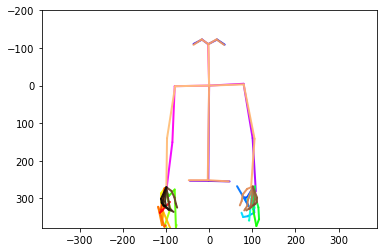

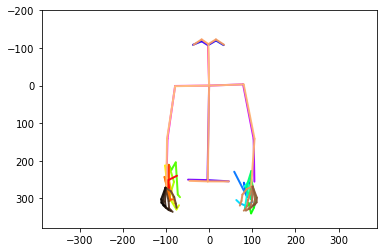

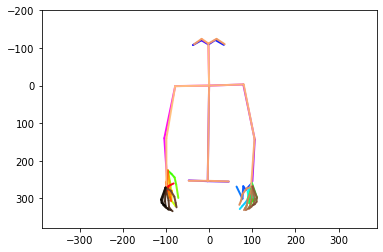

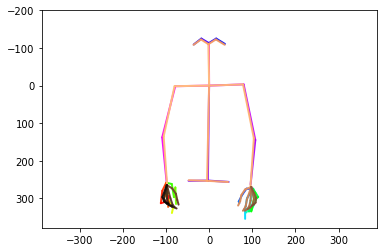

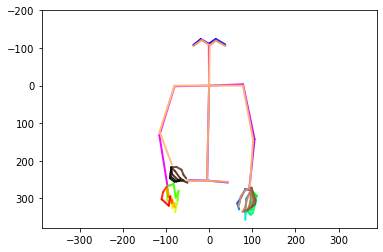

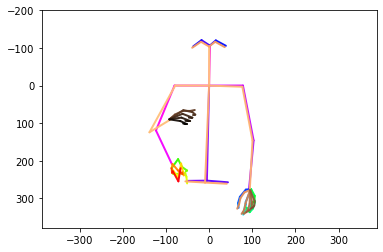

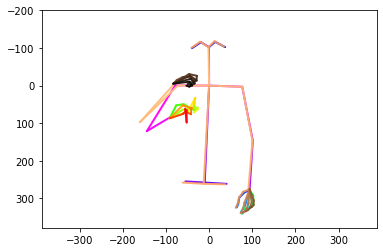

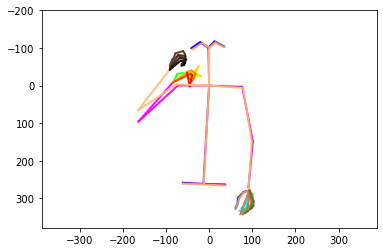

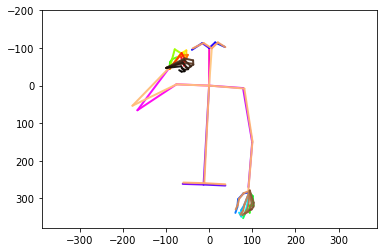

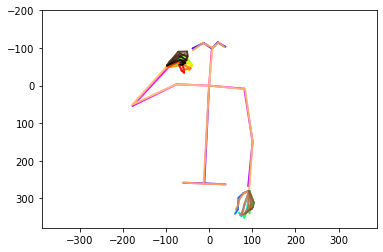

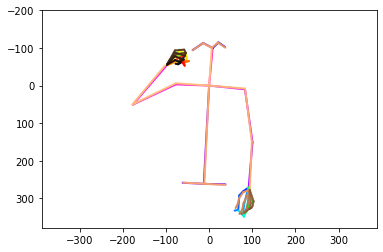

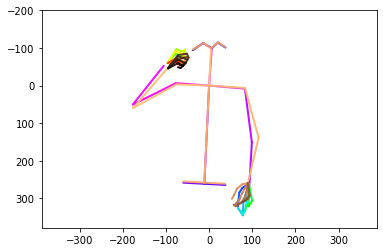

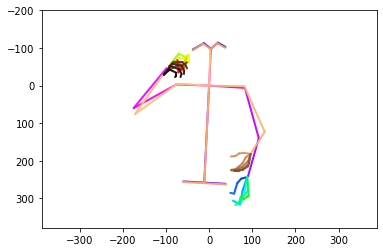

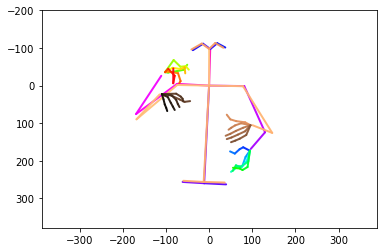

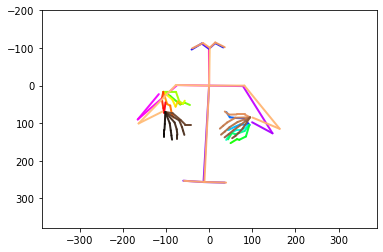

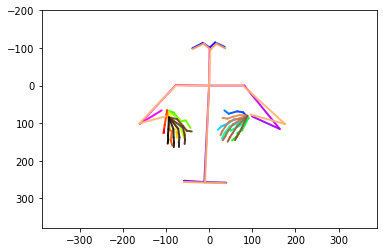

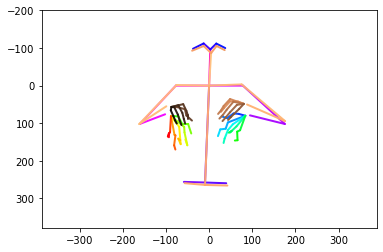

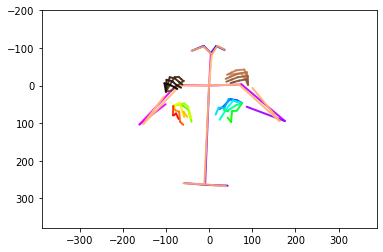

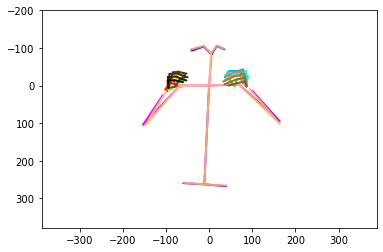

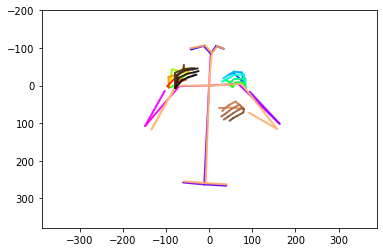

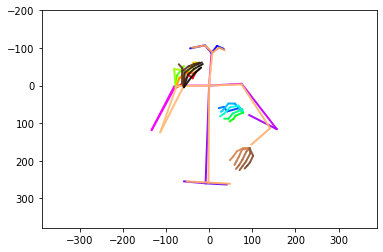

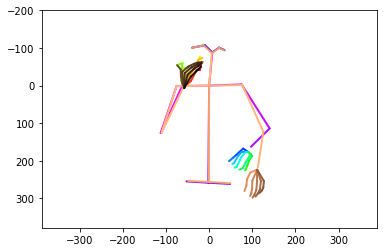

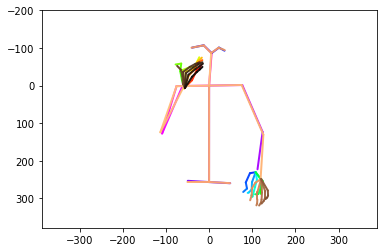

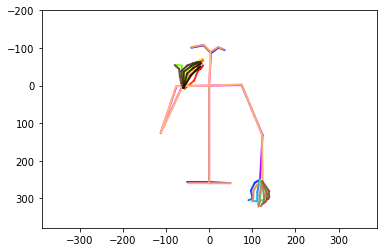

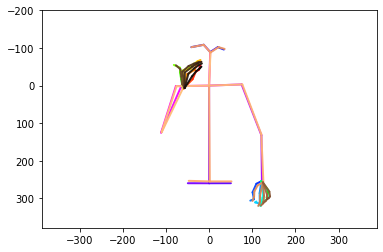

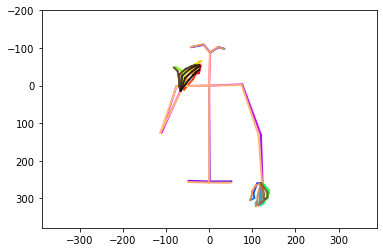

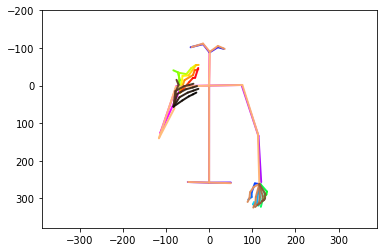

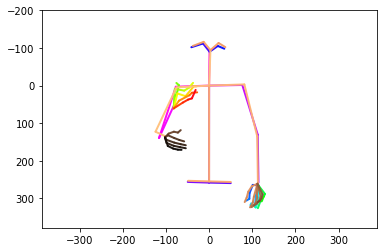

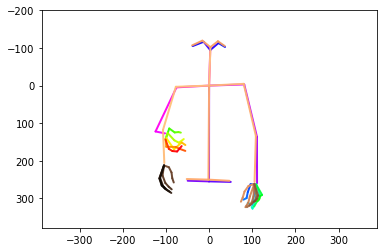

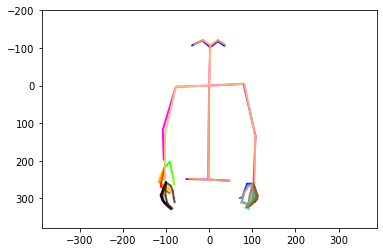

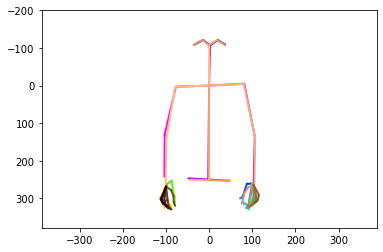

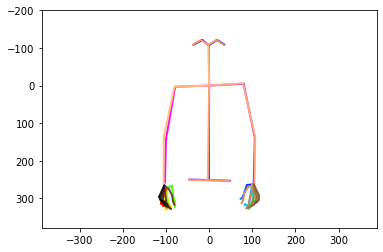

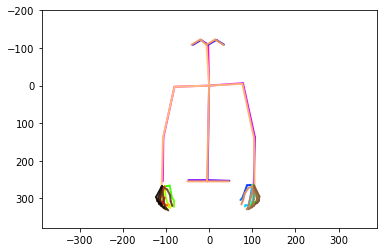

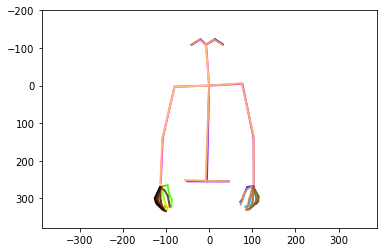

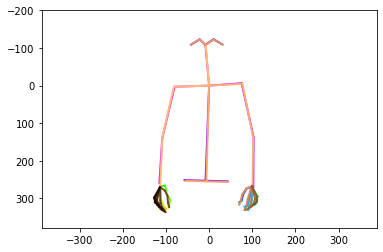

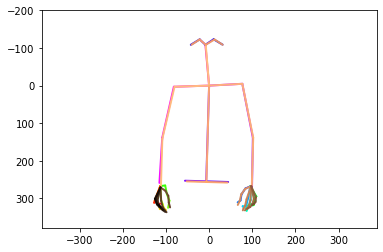

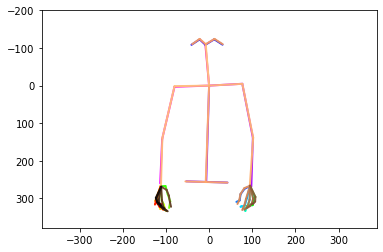

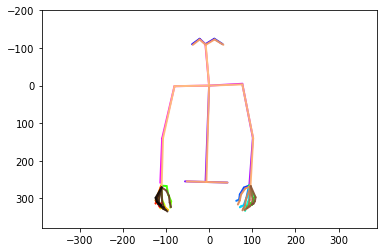

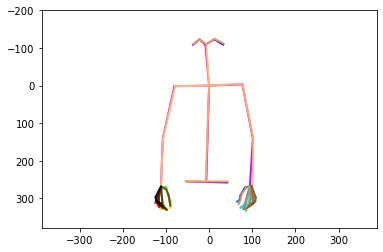

In [49]:
fig = plt.figure()

for i, pose in enumerate(vis_pose):
#     clear_output(wait=True)
    ax = plt.subplot(111)
    pose = skel.denormalize_pose(pose, test_dataset.mean, test_dataset.std)
    pose_gt = skel.denormalize_pose(vis_gt[i], test_dataset.mean, test_dataset.std)
#     print(pose.shape)
    skel.plot_pose2D(ax, pose)
    skel.plot_pose2D(ax, pose_gt, colormap='copper')
    plt.show()